In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt

# plot pandas dates
from pandas.tseries import converter
pd.plotting.register_matplotlib_converters()

# interactive graphs on jupyter notebook
import mpld3

# 1. Data Extraction
### 1.1 Candidates Data

In [2]:
candidate_data = pd.read_csv('prediction_candidates.csv', sep=';', dtype={'number': str})
# candidate_data.info()
# candidate_data.describe(include='all')
# candidate_data

### 1.2. Result Data

In [3]:
raw_data = pd.read_csv('4D_result.csv', sep=';', dtype={'number': str})
# raw_data.info()
# raw_data.describe(include='all')

# 2. Data Transformation

In [4]:
transform_data = raw_data.copy()
transform_data.loc[transform_data['company_code'] == 'DMC', 'company_code'] = 'Da Ma Cai'
transform_data.loc[transform_data['company_code'] == 'MAG', 'company_code'] = 'Magnum'
transform_data.loc[transform_data['company_code'] == 'ST', 'company_code'] = 'Sports Toto'

transform_data.loc[transform_data['category'] == 'FST', 'category'] = '1st'
transform_data.loc[transform_data['category'] == 'SCD', 'category'] = '2nd'
transform_data.loc[transform_data['category'] == 'TRD', 'category'] = '3rd'
transform_data.loc[transform_data['category'] == 'SP', 'category'] = 'Special'
transform_data.loc[transform_data['category'] == 'CONS', 'category'] = 'Consolation'
# transform_data

# 3. Data Filtering

In [5]:
date_from = transform_data.min()['draw_date']
date_to = transform_data.max()['draw_date']

# date_from = '2019-07-01'
# date_to = '2019-07-31'

company_code = 'Magnum'
result_data = transform_data[(transform_data.number != '----') &
                             (transform_data.company_code == company_code) &
                             (transform_data.draw_date >= date_from) &
                             (transform_data.draw_date <= date_to)]
result_data = result_data.sort_values(by=['draw_date', 'company_code', 'position'])
# result_data

# 4. Data Manipulation
### 4.1 Lookup for candidates occuring periods

In [6]:
result_dict = result_data.groupby('number').agg({
    'draw_date' : ', '.join,
    'category' : ', '.join
}).to_dict('index')

candidate_data['category'] = [row['number'] in result_dict and result_dict[row['number']]['category'] or ''
                                  for index, row in candidate_data.iterrows()]
candidate_data['draw_date'] = [row['number'] in result_dict and result_dict[row['number']]['draw_date'] or ''
                                   for index, row in candidate_data.iterrows()]

# candidate_data.to_csv(f'{company_code}_candidates_accurancy_{date_from}_{date_to}.csv', sep=';', index=None, header=True)

### 4.2 Data Pre-Processing

In [7]:
multi_period_candidate_indexes = list(candidate_data.index[candidate_data['category'].str.contains(',')])
for candidate_index in multi_period_candidate_indexes:
    tmp_data = candidate_data.iloc[candidate_index]
    draw_dates = tmp_data['draw_date'].split(',')
    categories = tmp_data['category'].split(',')
    
    # Distribute numbers occurred on multiple periods to new rows
    # e.g. 8152 appeared at 2019-07-03 and 2019-07-27
    for index, draw_date in enumerate(draw_dates):
        candidate_data = candidate_data.append({
            'number': tmp_data['number'],
            'pattern': tmp_data['pattern'],
            'group_4': tmp_data['group_4'],
            'group_3': tmp_data['group_3'],
            'group_2': tmp_data['group_2'],
            'group_1': tmp_data['group_1'],
            'odd_even': tmp_data['odd_even'],
            'big_small': tmp_data['big_small'],
            'category': categories[index].strip(),
            'draw_date': draw_date.strip(),
        }, ignore_index=True)

# Remove rows with aggregated periods
candidate_data = candidate_data.drop(multi_period_candidate_indexes)
candidate_data = candidate_data.sort_values(by=['number', 'draw_date'])

# 5. Accuracy Calculation

In [8]:
matched_results = []
total_price_count = 23
total_candidate_count = candidate_data.groupby('number').count()['draw_date'].count()

dates = list(result_data.groupby('draw_date').size().to_dict())
for date in dates:
    matched_data = candidate_data[(candidate_data['category'] != '') & (candidate_data['draw_date'] == date)]
    matched_count = matched_data.count()['number']
    matched_results.append({
        date: {
            'match_count': matched_count,
            'match_price_percent': round(matched_count / total_price_count, 4) * 100,
            'match_number_percent': round(matched_count / total_candidate_count, 4) * 100,
            'first_count': matched_data[matched_data['category'] == '1st'].count()['number'],
            'second_count': matched_data[matched_data['category'] == '2nd'].count()['number'],
            'third_count': matched_data[matched_data['category'] == '3rd'].count()['number'],
            'special_count': matched_data[matched_data['category'] == 'Special'].count()['number'],
            'consolation_count': matched_data[matched_data['category'] == 'Consolation'].count()['number'],
        }
    })

matched_results = sorted(matched_results, key=lambda x: list(x.keys())[0], reverse=False)
dates = [dt.strptime(list(matched_result.keys())[0], '%Y-%m-%d') for matched_result in matched_results]
match_count_list = [list(matched_result.values())[0]['match_count'] for matched_result in matched_results]
match_price_percent_list = [list(matched_result.values())[0]['match_price_percent'] for matched_result in matched_results]
match_number_percent_list = [list(matched_result.values())[0]['match_number_percent'] for matched_result in matched_results]
first_count_list = [list(matched_result.values())[0]['first_count'] for matched_result in matched_results]
second_count_list = [list(matched_result.values())[0]['second_count'] for matched_result in matched_results]
third_count_list = [list(matched_result.values())[0]['third_count'] for matched_result in matched_results]
special_count_list = [list(matched_result.values())[0]['special_count'] for matched_result in matched_results]
consolation_count_list = [list(matched_result.values())[0]['consolation_count'] for matched_result in matched_results]

# 7. Accuracy Visualization

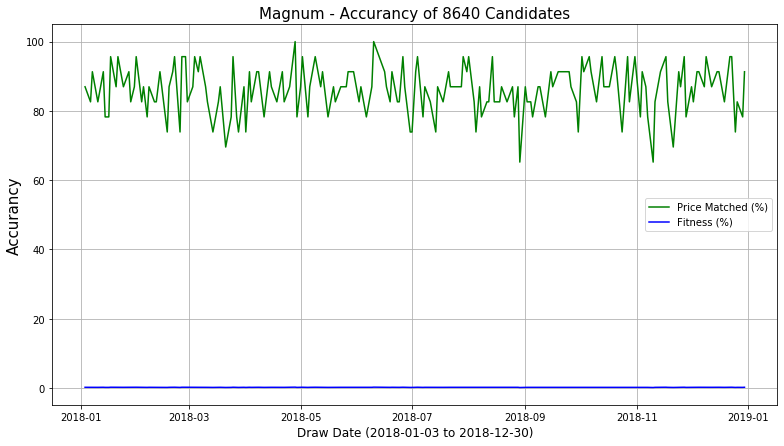

In [19]:
mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = [13, 7]

plt.plot(dates, match_price_percent_list, marker='None', c='g', ls='-', label='Price Matched (%)')
plt.plot(dates, match_number_percent_list, marker='None', c='b', ls='-', label='Fitness (%)')

plt.title(f'{company_code} - Accurancy of {total_candidate_count} Candidates', fontsize=15)
plt.xlabel(f'Draw Date ({date_from} to {date_to})', fontsize=12)
plt.ylabel('Accurancy', fontsize=15)
plt.legend()
plt.grid()
plt.show()

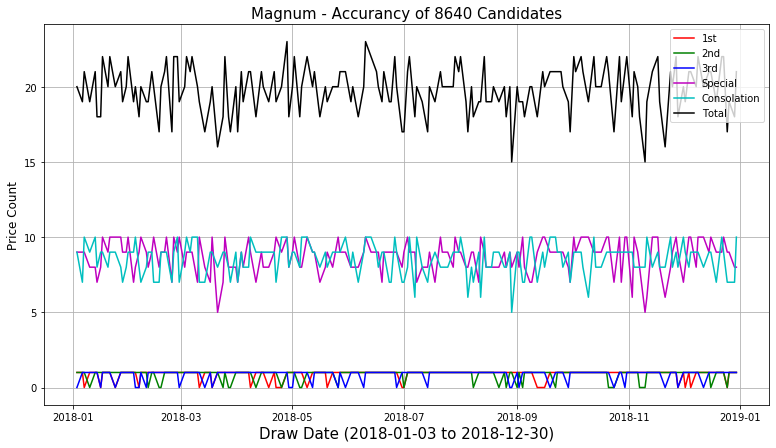

In [21]:
plt.plot(dates, first_count_list, marker='None', c='r', ls='-', label='1st')
plt.plot(dates, second_count_list, marker='None', c='g', ls='-', label='2nd')
plt.plot(dates, third_count_list, marker='None', c='b', ls='-', label='3rd')
plt.plot(dates, special_count_list, marker='None', c='m', ls='-', label='Special')
plt.plot(dates, consolation_count_list, marker='None', c='c', ls='-', label='Consolation')
plt.plot(dates, match_count_list, marker='None', c='k', ls='-', label='Total')

plt.title(f'{company_code} - Accurancy of {total_candidate_count} Candidates', fontsize=15)
plt.xlabel(f'Draw Date ({date_from} to {date_to})', fontsize=15)
plt.ylabel('Price Count', fontsize=12)
plt.legend()
plt.grid()
plt.show()